# Question 2: predictive modeling and scenario analysis 

## Split the data into training and testing sets. 

In [1]:
# import dependencies 
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../co2_World_Bank.csv')

In [3]:
from sklearn.preprocessing import StandardScaler


num_vars = df.select_dtypes(include=['int64', 'float64'])
num_vars.drop(['co2_total'], inplace=True, axis=1) # avoid rescaling the target variable


scaled = StandardScaler().fit_transform(num_vars)
df_scaled = pd.DataFrame(scaled, columns=num_vars.columns)



In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["co2_total", "country"])
y = df["co2_total"]
ids = df["country"] 

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    df_scaled, y, ids, test_size=0.2, random_state=1
)


## Train a regression model using the socio-economic and environmental indicators as predictors.

In [5]:
model = LinearRegression()

model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Evaluate the model's performance 

In [6]:
y_pred = model.predict(X_test)


results = pd.DataFrame({
    "country": ids_test,
    "real_co2": y_test,
    "pred_co2": y_pred, 
    "error" : (y_test - y_pred)
})

# for rating countries under and over estimated: 
top_countries = results.drop_duplicates(subset=['country'], keep='first')


In [7]:
# countries with over estimated predictions: 
top_under = top_countries.sort_values("error").head(10)
top_under



,country,real_co2,pred_co2,error
285,Brazil,479.5042,2541.983089,-2062.478889
955,Indonesia,656.6692,1817.666281,-1160.997081
1545,Nigeria,124.9024,985.574604,-860.672204
1358,Mexico,476.0570,1317.174900,-841.117900
1034,Japan,1326.7101,1886.740389,-560.030289
708,France,339.3458,790.953389,-451.607589
2193,United Kingdom,381.2854,805.734177,-424.448777
1604,Pakistan,218.6802,626.103768,-407.423568
2132,Turkiye,433.7457,807.577670,-373.831970
1671,Philippines,161.2883,505.563409,-344.275109


In [8]:
# countries with under estimated predictions: 
top_over = top_countries.sort_values("error", ascending=False).head(10)
top_over

,country,real_co2,pred_co2,error
415,China,12621.614700,11757.997760,863.616940
2201,United States,5244.071700,4625.656849,618.414851
1718,Russian Federation,1757.057400,1486.774026,270.283374
1464,Nauru,0.000000,-223.241477,223.241477
1754,San Marino,58.795778,-161.705894,220.501672
2216,Uruguay,6.852900,-210.336339,217.189239
733,Gabon,5.309600,-202.943243,208.252843
1780,Saudi Arabia,605.257600,412.502934,192.754666
1166,Lebanon,23.102600,-155.905401,179.008001
2269,Virgin Islands (U.S.),0.000200,-168.126117,168.126317


<Axes: >

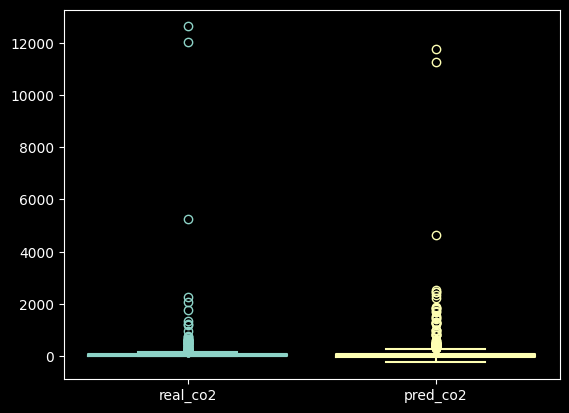

In [9]:
import seaborn as sns
# visualizartion of real and predicted values, focusing on it's dispersion

sns.boxplot(data=results[['real_co2', 'pred_co2']], fill=False)


C:\Users\salva\AppData\Local\Temp\ipykernel_19344\3090965474.py:6: RuntimeWarning: invalid value encountered in log1p
  results['pred_co2_log'] = results['pred_co2'].apply(lambda x: np.log1p(x))


<Axes: >

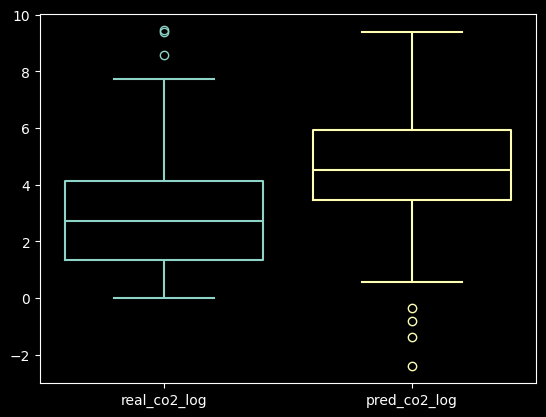

In [10]:
# visualization with log
log_cols = ["real_co2_log", "pred_co2_log"]


results['real_co2_log'] = results['real_co2'].apply(lambda x: np.log1p(x))
results['pred_co2_log'] = results['pred_co2'].apply(lambda x: np.log1p(x))

sns.boxplot(data=results[['real_co2_log', 'pred_co2_log']], fill=False)


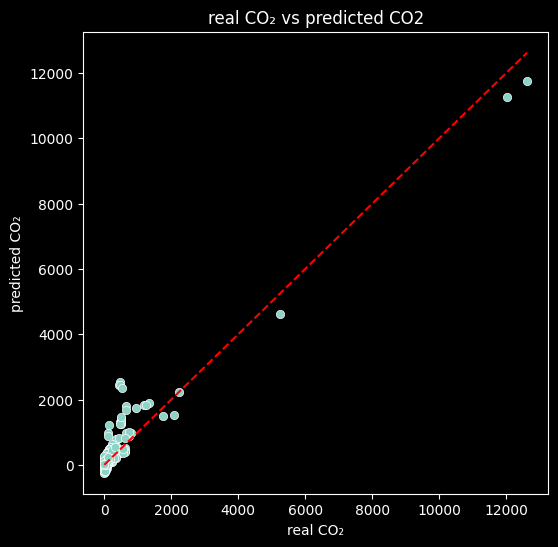

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")  # línea ideal
plt.xlabel("real CO₂")
plt.ylabel("predicted CO₂")
plt.title("real CO₂ vs predicted CO2")
plt.show()


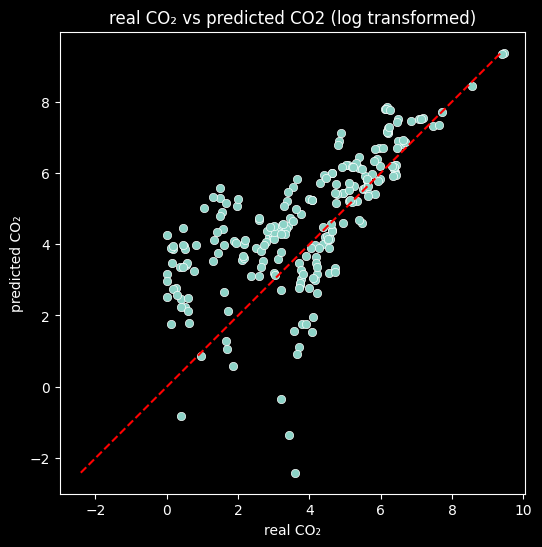

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = results, x='real_co2_log', y='pred_co2_log')

plt.plot([results['pred_co2_log'].min(), results['pred_co2_log'].max()],
         [results['pred_co2_log'].min(), results['pred_co2_log'].max()],
         color="red", linestyle="--")  # línea ideal
plt.xlabel("real CO₂")
plt.ylabel("predicted CO₂")
plt.title("real CO₂ vs predicted CO2 (log transformed)")
plt.show()


In [13]:
# summary of errors, real and predicted values
results[['real_co2', 'pred_co2', 'error']].describe()

,real_co2,pred_co2,error
count,465.000000,465.000000,465.000000
mean,158.512169,184.310299,-25.798130
std,868.043590,875.465122,271.044599
min,0.000000,-241.038276,-2062.478889
25%,2.773300,-50.282404,-38.343565
50%,14.136700,-1.136659,28.845055
75%,61.258600,87.663445,75.887653
max,12621.614700,11757.997760,863.616940


In [14]:
from sklearn.metrics import mean_squared_error, max_error, r2_score, mean_absolute_error
#  RMSE 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#  Máximo error absoluto 
max_err = max_error(y_test, y_pred)

# R² (adicional, muy usado) 
r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {max_err:.4f}")
print(f"R²: {r2:.4f}")

MAE: 128.0583
RMSE: 271.9793
Max Error: 2062.4789
R²: 0.9016


In [15]:
coefs = pd.DataFrame({
    "variable": X_train.columns,
    "coef": model.coef_
}).sort_values(by="coef", key=abs, ascending=False)

print(coefs.head(10))


             variable         coef
6          population  2113.368053
9           rural_pop -1502.886908
2                 gdp    99.604201
11          urban_pop   -71.865192
5   pop_growth_percen   -64.768409
0           energy_pc    55.987905
12   urban_pop_growth    53.811368
8          renewables   -36.092159
7     food_insecurity    32.005005
13             co2_pc    18.849017


# Scenario analysis 

In [17]:
# prepare sinthetic data (simulate an increase of 10% in gdp)
X_scenario = X_test.copy()  
X_scenario['gdp'] = X_scenario['gdp'] * 1.1


In [18]:
y_pred_original = model.predict(X_test)
y_pred_gdp_plus10 = model.predict(X_scenario)
pct_change = ((y_pred_gdp_plus10 - y_pred_original) / y_pred_original) * 100

results_gdp = pd.DataFrame({
    'country': ids_test,
    'original_co2': y_pred_original,
    'co2_gdp_plus10': y_pred_gdp_plus10,
    'pct_change': pct_change
})


In [19]:
top_countries_pct = results_gdp.drop_duplicates(subset=['country'], keep='first')

top_countries_pct.sort_values("pct_change").head(20)

,country,original_co2,co2_gdp_plus10,pct_change
1287,Maldives,1.341895,-0.854292,-163.663090
1145,Lao PDR,1.861879,-0.280539,-115.067529
987,Ireland,-0.910293,-0.262897,-71.119550
134,Azerbaijan,3.744355,1.816262,-51.493325
1891,Somalia,4.995368,2.840506,-43.137203
195,Belarus,6.178615,4.339908,-29.759217
920,Hungary,4.846658,3.486151,-28.071035
2157,Uganda,7.449833,5.411533,-27.360343
632,Eritrea,8.451944,6.303227,-25.422754
1453,Namibia,13.472307,11.325345,-15.936113


In [20]:
top_countries_pct.sort_values("pct_change", ascending=False).head(20)

,country,original_co2,co2_gdp_plus10,pct_change
994,Isle of Man,-0.298975,-2.475319,727.934095
107,Aruba,-0.560814,-2.758970,391.958449
2113,Tunisia,-0.744214,-2.687410,261.107193
1943,St. Kitts and Nevis,-1.136659,-3.345832,194.356598
389,Chad,-1.679274,-3.821316,127.557635
1379,Moldova,-3.267173,-5.429866,66.194631
348,Cambodia,-3.998187,-6.024608,50.683508
231,Bhutan,-6.420182,-8.623647,34.320911
845,Guatemala,-5.099666,-6.798526,33.313152
2077,Timor-Leste,-6.627249,-8.823901,33.145774


In [21]:
results_gdp['pct_change'].describe()

count    465.000000
mean       4.042901
std       46.553641
min     -260.130455
25%       -1.459854
50%        1.335747
75%        4.035723
max      727.934095
Name: pct_change, dtype: float64